In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np


# Exploratory Data Analysis

## Distribution count

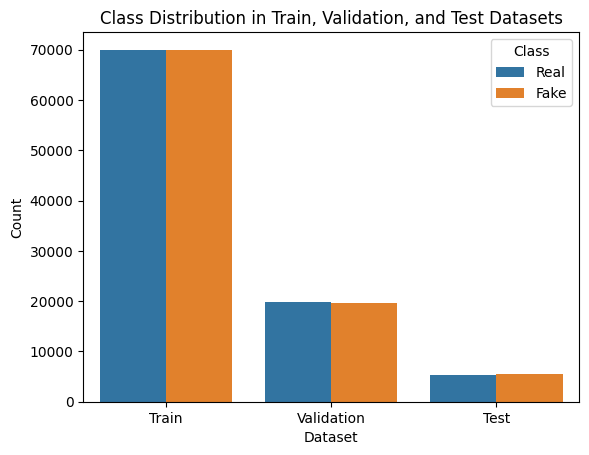

In [3]:
# Directories
dataset_dir = '/kaggle/input/deepfake-and-real-images/Dataset'
train_dir = os.path.join(dataset_dir, 'Train')
val_dir = os.path.join(dataset_dir, 'Validation')
test_dir = os.path.join(dataset_dir, 'Test')

# Function to count images in each category (Real/Fake)
def count_images_in_folder(folder_path):
    real_count = len(os.listdir(os.path.join(folder_path, 'Real')))
    fake_count = len(os.listdir(os.path.join(folder_path, 'Fake')))
    return real_count, fake_count

# Get counts for Train, Validation, and Test sets
train_real, train_fake = count_images_in_folder(train_dir)
val_real, val_fake = count_images_in_folder(val_dir)
test_real, test_fake = count_images_in_folder(test_dir)

# Creating a dataframe for easy visualization
data = {
    'Dataset': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['Real', 'Fake', 'Real', 'Fake', 'Real', 'Fake'],
    'Count': [train_real, train_fake, val_real, val_fake, test_real, test_fake]
}
df = pd.DataFrame(data)

# Plot the distribution
sns.barplot(x='Dataset', y='Count', hue='Class', data=df)
plt.title('Class Distribution in Train, Validation, and Test Datasets')
plt.show()


## Visualize Sample Images

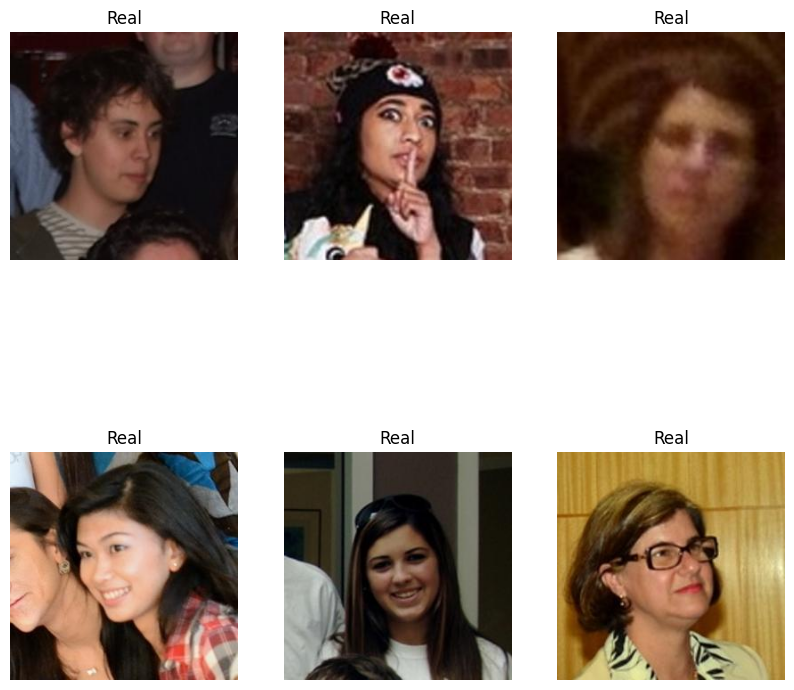

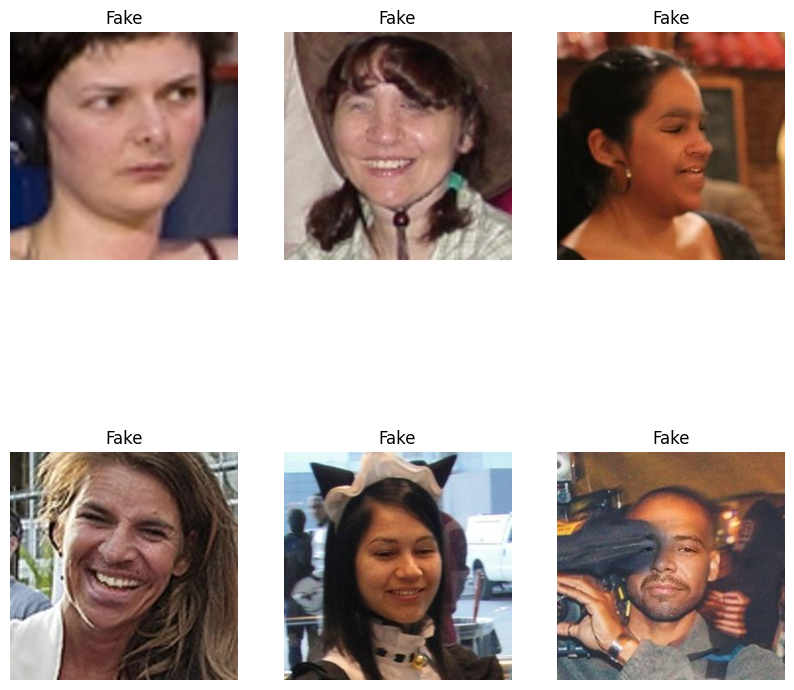

In [4]:
import random

def plot_sample_images(folder_path, class_label):
    class_dir = os.path.join(folder_path, class_label)
    image_names = random.sample(os.listdir(class_dir), 6)  # Randomly select 6 images
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_names):
        img_path = os.path.join(class_dir, image_name)
        img = Image.open(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

# Show random samples of Real and Fake images from the Train set
plot_sample_images(train_dir, 'Real')
plot_sample_images(train_dir, 'Fake')


# Load dataset

In [5]:
# Define ImageDataGenerator for train, validation, and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training set")
# Generate batches of tensor image data for training
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Train',
    target_size=(256, 256),   # Resize images to 224x224
    batch_size=400,
    class_mode='binary'       # Binary classification: Real (1) or Fake (0)
)

print("Loading Valildation set")
# For validation and testing
validation_generator = val_test_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Validation',
    target_size=(256, 256),
    batch_size=400,
    class_mode='binary'
)

print("Loading Testing set")
test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Test',
    target_size=(256, 256),
    batch_size=400,
    class_mode='binary'
)

# Check the class indices
print(train_generator.class_indices)  # Output: {'Fake': 0, 'Real': 1}

# Checking the size of dataset
print(f'Training set size: {train_generator.samples}')
print(f'Validation set size: {validation_generator.samples}')
print(f'Test set size: {test_generator.samples}')

Loading Training set
Found 140002 images belonging to 2 classes.
Loading Valildation set
Found 39428 images belonging to 2 classes.
Loading Testing set
Found 10905 images belonging to 2 classes.
{'Fake': 0, 'Real': 1}
Training set size: 140002
Validation set size: 39428
Test set size: 10905


# Build and train model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(256, 256, 3)):
    model = models.Sequential()

    # Convolutional Layer Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # Output: (128, 128, 32)

    # Convolutional Layer Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # Output: (64, 64, 64)
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    # Convolutional Layer Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # Output: (32, 32, 128)

    # Convolutional Layer Block 4
    # model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2, 2)))  # Output: (16, 16, 256)

    # Fully Connected Layers
    model.add(layers.Flatten())  # Flatten the output
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  

    return model

In [7]:
# Create the model
model = build_model()

In [8]:
# Compile the model
model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

In [9]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,301,949 (256.74 MB)

 Trainable params: 67,301,501 (256.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Train the model for a specified number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15  # You can adjust the number of epochs
)


Epoch 1/20


I0000 00:00:1729885690.721958     126 service.cc:145] XLA service 0x7a2630002160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729885690.722034     126 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-25 19:48:34.711185: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[400,3,256,256]{3,2,1,0}, f32[400,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-25 19:48:35.070566: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.359528632s
Trying algorithm eng0{} for conv

350/350 ━━━━━━━━━━━━━━━━━━━━ 1615s 4s/step - accuracy: 0.6952 - loss: 1.7212 - val_accuracy: 0.7023 - val_loss: 0.5972
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8625 - loss: 0.3248 - val_accuracy: 0.6754 - val_loss: 0.6320
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.9044 - loss: 0.2288 - val_accuracy: 0.8928 - val_loss: 0.2559
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - accuracy: 0.9200 - loss: 0.1929 - val_accuracy: 0.8333 - val_loss: 0.4279
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.9558 - loss: 0.1126 - val_accuracy: 0.9015 - val_loss: 0.2634
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step - accuracy: 0.9675 - loss: 0.0807 - val_accuracy: 0.9123 - val_loss: 0.2302
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9750 - loss: 0.0646 - val_accuracy: 0.8819 - val_loss: 0.3877
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - accuracy: 0.9700 - loss: 0.0721 - val_accuracy: 

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


28/28 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.8260 - loss: 0.7618
Test Loss: 0.7650, Test Accuracy: 0.8266


In [12]:
from keras.models import load_model

model.save("projectthingythirdtry.h5")
# model.save("neural_net")
# Saves the entire model, including weights and architecture

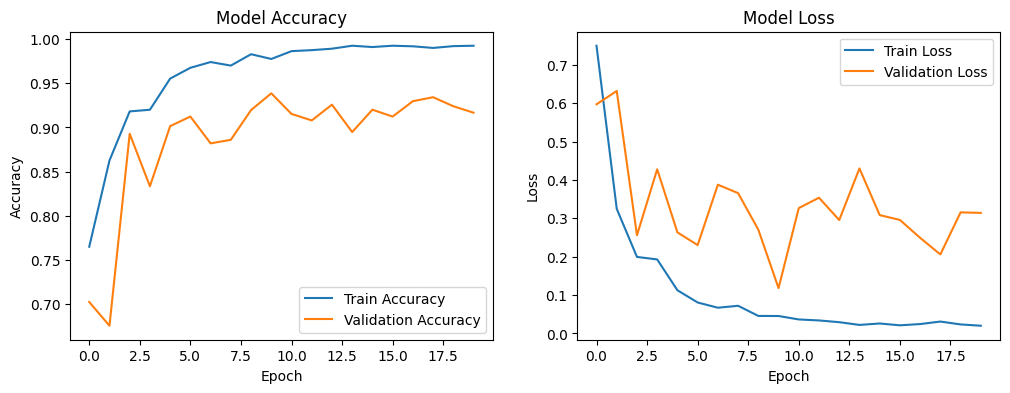

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Testing the model

## Confusion Matrix

28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


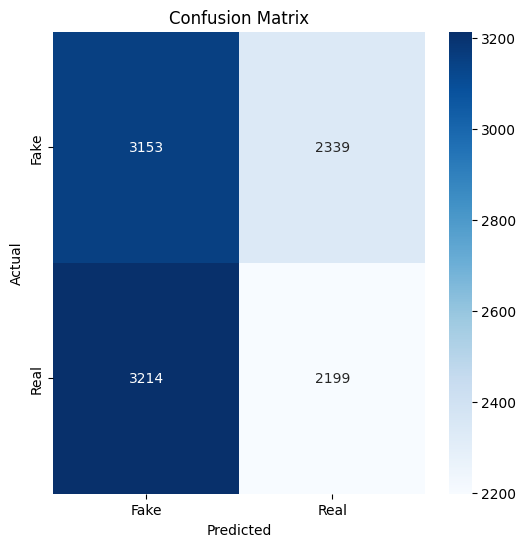

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Convert probabilities to class labels

# Get true labels
true_classes = test_generator.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


## Classification Report

In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
class_labels = ['Fake', 'Real']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

        Fake       0.50      0.57      0.53      5492
        Real       0.48      0.41      0.44      5413

    accuracy                           0.49     10905
   macro avg       0.49      0.49      0.49     10905
weighted avg       0.49      0.49      0.49     10905



## Visualizing Some Test Set Results with Predictions

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step


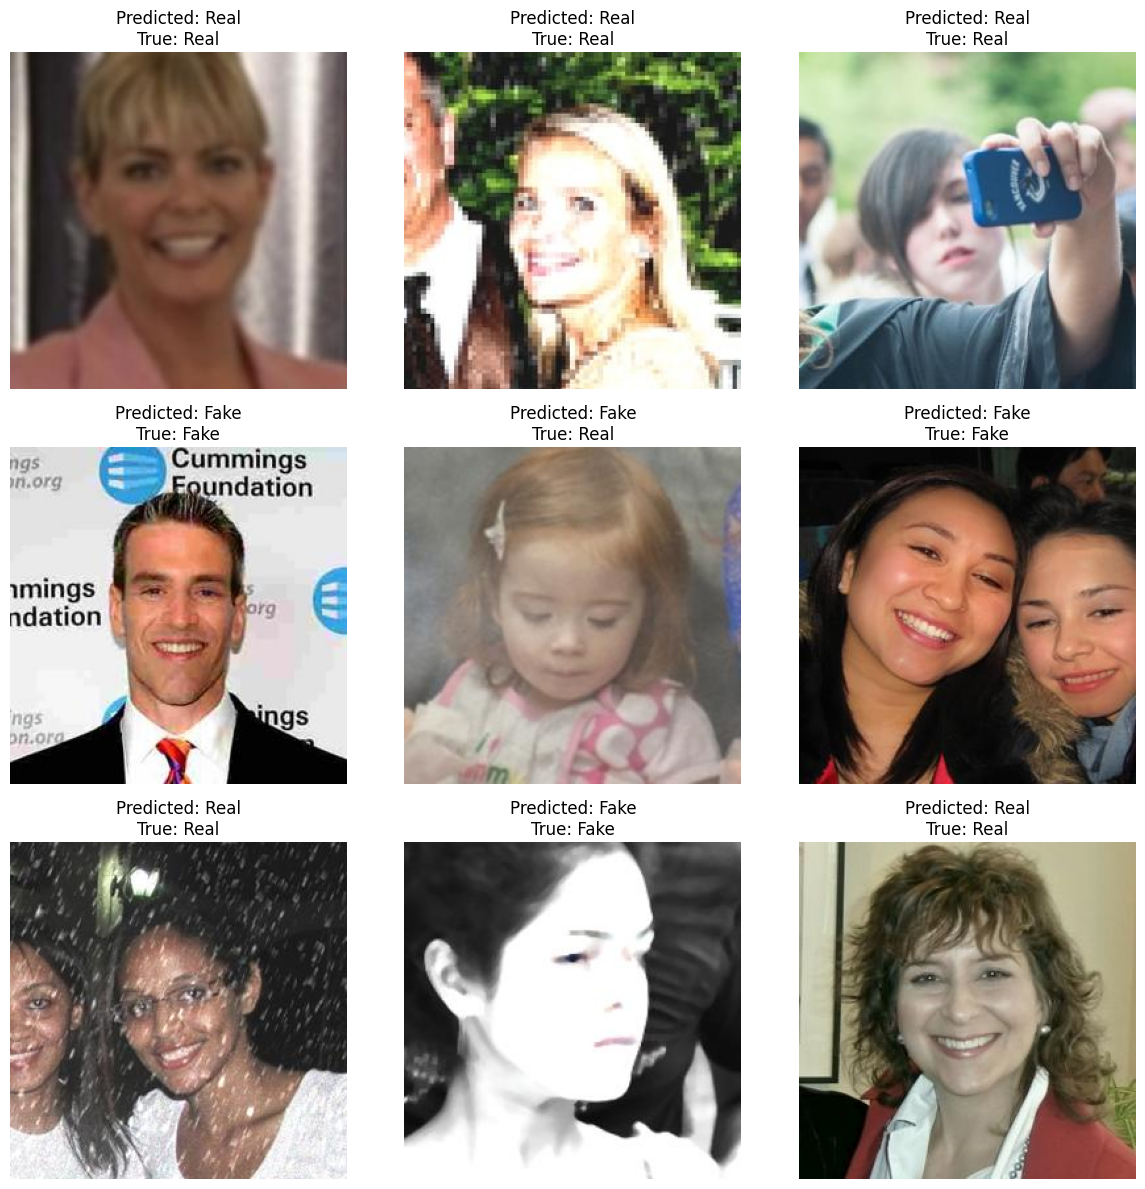

In [16]:
# Get some test images and corresponding true labels
test_images, test_labels = next(test_generator)

# Predict the classes for these test images
predictions = model.predict(test_images)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Convert probabilities to class labels

# Plot some images with their predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {'Real' if predicted_classes[i] == 1 else 'Fake'}\nTrue: {'Real' if test_labels[i] == 1 else 'Fake'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


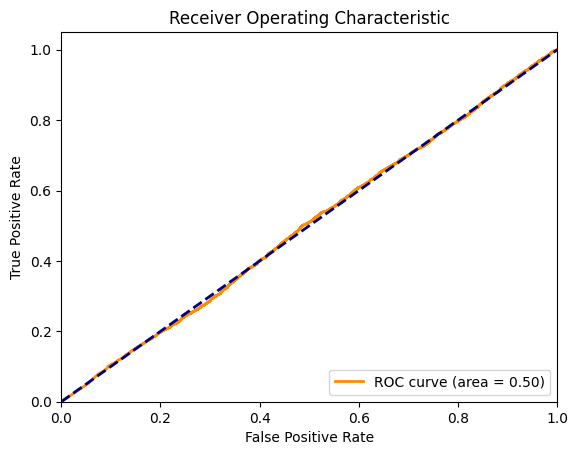

In [17]:
from sklearn.metrics import roc_curve, auc

# Get true labels and predicted probabilities
test_generator.reset()
y_pred_prob = model.predict(test_generator)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
